## Preprocessing: Tools

#### Main Imports

In [0]:
! pip install pyLDAvis

from IPython.display import clear_output

import pprint
import numpy as np
import nltk
nltk.download('wordnet')
import re

import spacy
spacynlp = spacy.load('en_core_web_sm')

import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this

import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

import time

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation

nltk.download('stopwords')

from nltk.corpus import stopwords
stop = set(stopwords.words('english'))

import string
exclude = set(string.punctuation)

from nltk.stem.wordnet import WordNetLemmatizer

lemma = WordNetLemmatizer()

def clean(doc):
    stop_free = " ".join([i for i in doc.lower().split() if i not in stop])
    stop_free = stop_free.replace("-", " ")
    punc_free = ''.join(ch for ch in stop_free if ch not in exclude)
    normalized = " ".join(lemma.lemmatize(word) for word in punc_free.split())
    return normalized 
  
clear_output()

#### Get CIK for a Ticker

In [0]:
from bs4 import BeautifulSoup
import requests
from urllib.parse import urlparse

def get_CIK(ticker):
    URL = "https://www.sec.gov/cgi-bin/browse-edgar?CIK="+ticker+"&owner=exclude&action=getcompany"
    page = requests.get(URL)
    soup = BeautifulSoup(page.text, "html.parser")
    CIK = soup.find(attrs={"name": "CIK"})
    return CIK["value"]

#### Functions to Plot Heatmap and Get the Line Items from Financial Statements for a Ticker

In [0]:
import seaborn as sns

def make_heatmap(results):
    fig = plt.figure(figsize=(10,6))
  
    inc_lines_in_call = results.sum().sort_values()
    inc_lines_in_call = inc_lines_in_call[inc_lines_in_call > 0].index.values

    if inc_lines_in_call.any():
        sns.heatmap(results[inc_lines_in_call].T)
    else:
        sns.heatmap(results.T)
    
    plt.show()
    
def get_inc_stmt_lines(ticker):
    cik=str(int(get_CIK(ticker)))
    items_to_find = df_fin_stmt_items[df_fin_stmt_items["cik"]==cik]
    #net_inc = items_to_find[items_to_find["plabel"].str.match("[N|n]et.*[I|i]ncome")]["line"].min()
    #items_to_find = items_to_find[items_to_find["line"]<=net_inc]
    items_to_find = list(items_to_find["plabel"])+list(items_to_find["tlabel"])

    items_to_find = [item.lower().replace(",","") for item in items_to_find]
    #items_to_find += [item.replace("profit","margin") for item in items_to_find if "profit" in item]
    #items_to_find += ["of sales","of revenues","of revenue"]
    #items_to_find += [item.replace("net ","") for item in items_to_find if "net" in item]
    
    return list(np.unique(items_to_find))

#### Function to Print Top Words from sklearn Models

In [0]:
def print_top_words(model, feature_names, n_top_words): 
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d: " % topic_idx
        print(message)
        message = " ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]])
        pprint.pprint(message)
        print()

## Preprocessing: Bring in Data


#### Read Call Pickle and Build Meta-data and Text DataFrames

In [250]:
data_directory = "/content/gdrive/My Drive/DATS6450 - Labadie - Data/"

# import the call dataset
import pandas as pd
import numpy as np
import pickle
import os

from google.colab import drive
drive.mount('/content/gdrive')

if os.path.exists(data_directory+"ProcessedCallsPickleUpdated_v2"):
    pfile = open(data_directory+"ProcessedCallsPickleUpdated_v2", "rb")
    calls = pickle.load(pfile)                 
    pfile.close()
    
df_metadata = calls["metadata"]
df_text = calls["text"]
  
clear_output()

print("Metadata Shape:",df_metadata.shape, "Text Shape:",df_text.shape)

Metadata Shape: (5101, 6) Text Shape: (640132, 11)


#### List of Companies and Industries/Sectors

In [251]:
company_list = pd.read_csv(data_directory+"companylist.csv")
company_list.shape

(5285, 9)

#### Tickers -> CIK:  Used to connect to financial statements from SEC

In [252]:
cik_ticker_map = pd.read_csv(data_directory+"cik_ticker.csv",sep="|",dtype={"CIK":object})
cik_ticker_map.shape

(13737, 8)

#### Financial Statement Data

In [0]:
directory=data_directory+"2018q4/"

filename = directory + "sub.txt"
df_sub = pd.read_table(filename,dtype={"cik":object})

filename = directory + "tag.txt"
df_tag = pd.read_table(filename,dtype={"cik":object})

filename = directory + "pre.txt"
df_pre = pd.read_table(filename,dtype={"cik":object})

filename = directory + "num.txt"
df_num = pd.read_table(filename,dtype={"cik":object})

df_fin_stmt = df_sub.merge(df_pre).merge(df_num).merge(df_tag)
df_fin_stmt_items = df_fin_stmt[df_fin_stmt["stmt"]=="IS"][["cik","line","plabel","tlabel"]].drop_duplicates()

## Preprocessing: Create a List of Tickers to Analyze

In [254]:
industry="Industrial Machinery/Components"
ticker_list = list(company_list[(company_list["Industry"]==industry)]["Symbol"])

calls_to_use = df_metadata[(df_metadata["ticker"].isin(ticker_list))].sort_values(by=["ticker"])
print("Number of Calls:",calls_to_use.shape[0])

Number of Calls: 183


<br>
<br>
<hr>
## Idenitify Compliance Paragraphs using Kmeans

In [0]:
corpus, call_names, paragraph_nums, corpus_whole_calls, call_names_whole_calls = [], [], [], [], []
for _, row in calls_to_use.iterrows():
    prepared_remarks = df_text[df_text["Link"]==row["Link"]]
    prepared_remarks = prepared_remarks[(prepared_remarks["Call Section"]=="Prepared Remarks")&
                                        (prepared_remarks["Speaker"]!="Operator")]
    
    corpus += list(prepared_remarks["Cleaned Text"])
    call_names += list(prepared_remarks.index)
    paragraph_nums  += list(prepared_remarks["Call Paragraph Num"])
    
    corpus_whole_calls.append(" ".join(list(prepared_remarks["Cleaned Text"])))
    call_names_whole_calls.append(row["ticker"] + " " + row["period"])

In [256]:
# find common phrases at the whole call level
vectorizer = CountVectorizer(ngram_range=(2,2), min_df=0.9, binary=True)
X = vectorizer.fit_transform(corpus_whole_calls)
df = pd.DataFrame(data=X.toarray(), index=call_names_whole_calls, columns=vectorizer.get_feature_names())
keywords_by_doc = set(df.columns)


# find phrases at the paragraph level`
vectorizer = CountVectorizer(ngram_range=(2,3), min_df=0.02, max_df=0.075, binary=True)
X = vectorizer.fit_transform(corpus)
df = pd.DataFrame(data=X.toarray(), index=call_names, columns=vectorizer.get_feature_names())
df["Paragraph Location"] = paragraph_nums
keywords_by_paragraph = set(df.columns)


# kmeans
from sklearn.cluster import KMeans
km = KMeans(n_clusters=2)

cols = list(set(df.columns)-set(["Prediction"]))
cols = list(keywords_by_doc.intersection(keywords_by_paragraph))
km.fit(df.loc[:,cols].values)

df["Prediction"] = km.labels_
low_occurence_class = df["Prediction"].value_counts().sort_values().index[0]
compliance_paragraphs = df.loc[df["Prediction"]==low_occurence_class,["Prediction","Paragraph Location"]].index

print(df["Prediction"].value_counts().sort_values())
print()

1     236
0    6961
Name: Prediction, dtype: int64



<br>
<br>
<hr>
## Testing Very Manual Cleaning for Modeling

#### Very Manual Cleaning Mechanism


In [0]:
stopwords_names = pd.read_csv(data_directory+"StopWords_Names.txt",header=None,sep="|")
stopwords_names[0]=stopwords_names[0].str.lower().str.strip()
stopwords_names = list(stopwords_names[0].dropna().drop_duplicates().sort_values())

stopwords_generic = pd.read_csv(data_directory+"StopWords_Generic.txt",header=None)
stopwords_generic = list(stopwords_generic.loc[:,0].str.lower())
stopwords_generic += ["quarter","year","us","million","billion","thousand","will","think","like",
                      "approximately", "fiscal", "business", "thank", "significant","across","driving","drive",
                      "industry","already","new","types","type","please","joining","recorded","today","midpoint",
                      "innings","pleased","gaap","non","period","profit","right","effective","date","time",
                      "month","results","actually","compared","per", "prior", "rate", "share", "net", "adjustment",
                      "also"]

stopwords_generic += ['sales', 'income', 'operating', 'diluted', 'up', 'without', 'division', 'earnings', 'adjusted', 'excluding', 'gross', 'margin', 'decreased', 'growth', 'increased', 'the', 'one', 'due', 'ebitda', 'grew', 'year', 'order', 'industrial', 'higher', 'increase', 'strong']
stopwords_generic += ['much', 'priority', 'deliver', 'components', 'favorable', 'day', 'local', 'timing', 'deliveries', 'impacted', 'shipments', 'implementing', 'finished', 'negatively', 'unfavorable', 'summarize', 'world', 'mess', 'priorities']

# stopwords_generic.remove('up')
# stopwords_generic.remove('down')

stopwords_generic += stopwords_names


def clean_paragraph_very_manual(paragraph):
    output = paragraph
    output = re.sub(r' \d+[.|,]?\d+', ' ', output)
    output = re.sub(r'\d+', '', output)
    
    output = re.sub(r'[W|w]e\'[r|v]e', '', output)
    output = re.sub(r'[W|w]e\'d', '', output)
    output = re.sub(r'[W|w]e\'ll', '', output)
    output = re.sub(r'[Y|y]ou\'ll', '', output)
    output = re.sub(r'I\'ll', '', output)
    output = re.sub(r'I\'m', '', output)
    output = re.sub(r'[I|i]t\'s', '', output)
    output = re.sub(r'[T|t]hat\'s', '', output)
    output = re.sub(r'[Y|y]ou(\'d)? ', ' ', output)
    output = re.sub(r'[Y|y]es ', ' ', output)
    output = re.sub(r'[N|o]o ', '', output)
    output = re.sub(r'[F|f]irst', '', output)
    output = re.sub(r'[S|s]econd', '', output)
    output = re.sub(r'[T|t]hird', '', output)
    output = re.sub(r'[F|f]ourth', '', output)
    output = re.sub(r'basis ?points', '', output)
    output = re.sub(r'as well as ', ' ', output)
    output = re.sub(r'earnings call', '', output)
    output = re.sub(r'[G|g]ood (morning|afternoon)', '', output)

    output = re.sub(r'[\%|$]', '', output)
    output = re.sub(r'[,|;|-]', ' ', output)
    output = re.sub(r' [a|I] ', ' ', output)
    output = re.sub(r'^[A|I] ', ' ', output)
        
    for word in stopwords_generic:
        pattern = '\s'+word+'\.'
        output = re.sub(str(pattern), '.', output)
    
    #paragraph = paragraph.replace(" of revenue"," ").replace(" of revenues"," ").replace(" of sales"," ")
    
    querywords = output.split()
    resultwords  = [word for word in querywords if word.lower() not in stopwords_generic]
    output = ' '.join(resultwords)

    return output

#### Testing Very Manual Cleaning Function

In [0]:
prepared_remarks = df_text[(df_text["Call Section"]=="Prepared Remarks")&
                           (df_text["Speaker"]!="Operator")]
prepared_remarks = prepared_remarks.loc[prepared_remarks.index.difference(compliance_paragraphs)]
 
for x in range(0,2):
    print(prepared_remarks.iloc[x,]["Link"])
    pprint.pprint(prepared_remarks.iloc[x,]["Text"])
    print()
    pprint.pprint(clean_paragraph_very_manual(prepared_remarks.iloc[x,]["Text"]))
    print()
    
clear_output()

#### Topic Modeling using Very Manual Cleaning

In [430]:
# builds the corpus at paragraph and entire call level
num_calls = 10
corpus, named_ents, call_names, paragraph_nums, corpus_whole_calls, call_names_whole_calls = [], [], [], [], [], []
for _, row in calls_to_use[0:num_calls].iterrows():
    link = row["Link"] 
    print(link)

    prepared_remarks = df_text[(df_text["Call Section"]=="Prepared Remarks")&
                               (df_text["Speaker"]!="Operator")&
                               (df_text["Link"]==link)]
    prepared_remarks = prepared_remarks.loc[prepared_remarks.index.difference(compliance_paragraphs)]
    cleaned_text_for_call = [clean_paragraph_very_manual(paragraph) for paragraph in prepared_remarks["Text"]]

    corpus += cleaned_text_for_call
    call_names += list(prepared_remarks.index)
    paragraph_nums  += list(prepared_remarks["Call Paragraph Num"])
    
    corpus_whole_calls.append(" ".join(cleaned_text_for_call))
    call_names_whole_calls.append(row["ticker"] + " " + row["period"])

https://www.fool.com/earnings/call-transcripts/2018/11/01/aaon-inc-aaon-q3-2018-earnings-conference-call-tra.aspx
https://www.fool.com/earnings/call-transcripts/2019/03/02/aaon-inc-aaon-q4-2018-earnings-conference-call-tra.aspx
https://www.fool.com/earnings/call-transcripts/2019/02/28/acacia-mining-aca-q4-2018-earnings-conference-call.aspx
https://www.fool.com/earnings/call-transcripts/2019/02/08/axcelis-technologies-acls-q4-2018-earnings-confere.aspx
https://www.fool.com/earnings/call-transcripts/2018/11/01/axcelis-technologies-inc-acls-q3-2018-earnings-con.aspx
https://www.fool.com/earnings/call-transcripts/2019/02/05/advanced-energy-industries-aeis-q4-2018-earnings-c.aspx
https://www.fool.com/earnings/call-transcripts/2019/02/06/agco-agco-q4-2018-earnings-conference-call-transcr.aspx
https://www.fool.com/earnings/call-transcripts/2019/02/21/altra-industrial-motion-corp-aimc-q4-2018-earnings.aspx
https://www.fool.com/earnings/call-transcripts/2018/10/26/altra-holdings-aimc-q3-2018-ea

In [0]:
# assign corpus level for modeling
if False:
    docs = corpus_whole_calls
    doc_names = call_names_whole_calls
    n_components = num_calls * 3
else:
    n_components = num_calls * 5

    
# builds the topic model    
vectorizer = TfidfVectorizer(stop_words=None, lowercase=True)
#vectorizer = CountVectorizer(binary=False, lowercase=True, max_df=0.25)
vectors = vectorizer.fit_transform(docs)
feature_names = vectorizer.get_feature_names()
results = pd.DataFrame(data=vectors.toarray(), index=doc_names, columns=vectorizer.get_feature_names())

n_top_words = 30

model = LatentDirichletAllocation(n_components=n_components,
                                  max_iter=5,
                                  learning_method='online',
                                  learning_offset=50,
                                  random_state=0).fit(vectors)
#print_top_words(model, feature_names, n_top_words)

W = model.fit_transform(vectors)
df_topics = pd.DataFrame(W,index=doc_names)

In [420]:
num_words = 15
print(results.head().apply(lambda s: s.nlargest(num_words).index.tolist(), axis=1))
print(results.head().apply(lambda s: s.nlargest(num_words).tolist(), axis=1))

AAON Q3 2018 10    [bonus, act, tax, employee, lowered, taxes, fe...
AAON Q3 2018 11    [workforce, occurred, company, seasonality, an...
AAON Q3 2018 12    [decrease, sg, percentage, administrative, sel...
AAON Q3 2018 13    [tax, estimated, federal, lowering, discrete, ...
AAON Q3 2018 14    [shares, per, based, ago, versus, aaon, abilit...
dtype: object
AAON Q3 2018 10    [0.47473491832019626, 0.40271267609945105, 0.2...
AAON Q3 2018 11    [0.4424676236316631, 0.41967608483662044, 0.37...
AAON Q3 2018 12    [0.4457437319631061, 0.4352755930258387, 0.409...
AAON Q3 2018 13    [0.582928471217687, 0.24285825253253107, 0.230...
AAON Q3 2018 14    [0.7536638608351289, 0.3662109085844133, 0.327...
dtype: object


In [429]:
callID = "ALG Q3 2018 11"
c1 = results.loc[callID].sort_values(ascending=False).head(12)
c2 = df_topics.loc[callID].sort_values(ascending=False).head()

print(c1)
print()
print(c2)

margins         0.262728
offset          0.240689
implemented     0.210457
aftermarket     0.210457
relative        0.210457
constrained     0.210457
squeezed        0.210457
constraining    0.210457
shortfall       0.196212
purchasing      0.186105
compares        0.178265
vacuum          0.171860
Name: ALG Q3 2018 11, dtype: float64

124    0.853322
149    0.000984
46     0.000984
52     0.000984
51     0.000984
Name: ALG Q3 2018 11, dtype: float64


In [427]:
topic_num = 124
message = " ".join([feature_names[i] for i in model.components_[topic_num].argsort()[:-n_top_words - 1:-1]])
pprint.pprint(message)

('percentage relative mentioned actions margins offset for growing vacuum '
 'productivity pricing foundry compares part shortfall purchasing initiatives '
 'japanese mind turns organic internal backlogs improvements factors '
 'comfortable performance acquisition southeast investments')


In [428]:
df_topics[topic_num].sort_values(ascending=False).head(10)

ALG Q3 2018 11     0.853322
ACLS Q4 2018 24    0.006667
AAON Q3 2018 8     0.006667
AAON Q3 2018 14    0.006667
AIMC Q3 2018 5     0.002818
AIMC Q4 2018 7     0.002818
AGCO Q4 2018 5     0.002766
ALG Q3 2018 7      0.002766
AAON Q3 2018 25    0.002763
ACLS Q3 2018 16    0.002763
Name: 124, dtype: float64

In [344]:
word="weather"
results[results[word]>0][word].sort_values(ascending=False)

ACA Q4 2018 27    0.215643
ACA Q4 2018 26    0.160761
ACA Q4 2018 16    0.154570
ALG Q3 2018 9     0.127225
Name: weather, dtype: float64

In [424]:
pprint.pprint(df_text.loc[callID]["Text"])

('European division third quarter 2018 sales were $39.4 million, or about 8.7% '
 'lower than the third quarter of 2017. Without a slightly unfavorable '
 "currency translation effect, this division's local currency sales were down "
 '8.2%, compared to the prior year third quarter. Year-to-date this division '
 'sales were up 9.8%, and also grew 3% without the benefit of favorable '
 'currency translation. Our European sales were negatively impacted by delayed '
 'shipments from our French vacuum truck facility, while much of this mess '
 '(ph) was the timing of finished product deliveries to customers, much of it '
 'was also due to delayed receipts of components from suppliers.')


<br>
<br>
<hr>
## Topic Modeling:  Analyze Paragraphs using Financial Statements

#### Build Line Items Vocabulary

In [0]:
line_items = []

num_calls = -1
for _, row in calls_to_use[0:num_calls].iterrows():
    line_items+=get_inc_stmt_lines(row["ticker"])
    
line_items=set(line_items)

max_ngram = np.max([len(item.split()) for item in line_items])
min_ngram = np.min([len(item.split()) for item in line_items])

#### Manual Adds to Vocabulary

In [0]:
line_items.add("tax cuts")
line_items.add("tariff")
line_items.add("tariffs")
line_items.add("white house")
line_items.add("ebitda")
line_items.add("ebitda margins")
line_items.add("ebitda margin")
line_items.add("china")

#### Perform Cleaning of a Paragraph Based on Financial "Lingo"

In [0]:
def clean_paragraph(paragraph):
    #paragraph = paragraph.replace(" of revenue"," ").replace(" of revenues"," ").replace(" of sales"," ")
    return paragraph

#### Analyze Usage of Terms from Financial Statements on Earnings Calls
This looks across all calls and builds a dictionary of all the terms used both in financial statements and earnings.

In [0]:
prepared_remarks = df_text[(df_text["Call Section"]=="Prepared Remarks")&
                           (df_text["Speaker"]!="Operator")&
                           (df_text["ticker"].isin(ticker_list))]

corpus = list(prepared_remarks["Text"])
#corpus = [clean_paragraph(paragraph) for paragraph in corpus]

tfidf_vectorizer = TfidfVectorizer(ngram_range=(min_ngram, max_ngram),vocabulary=line_items)
tfidf = tfidf_vectorizer.fit_transform(corpus)

results = pd.DataFrame(data=tfidf.toarray(), index=prepared_remarks.index.values, columns=tfidf_vectorizer.get_feature_names())
inc_lines_in_call = results.sum().sort_values()
inc_lines_in_call = list(inc_lines_in_call[inc_lines_in_call > 0].index.values)
results = results[inc_lines_in_call]

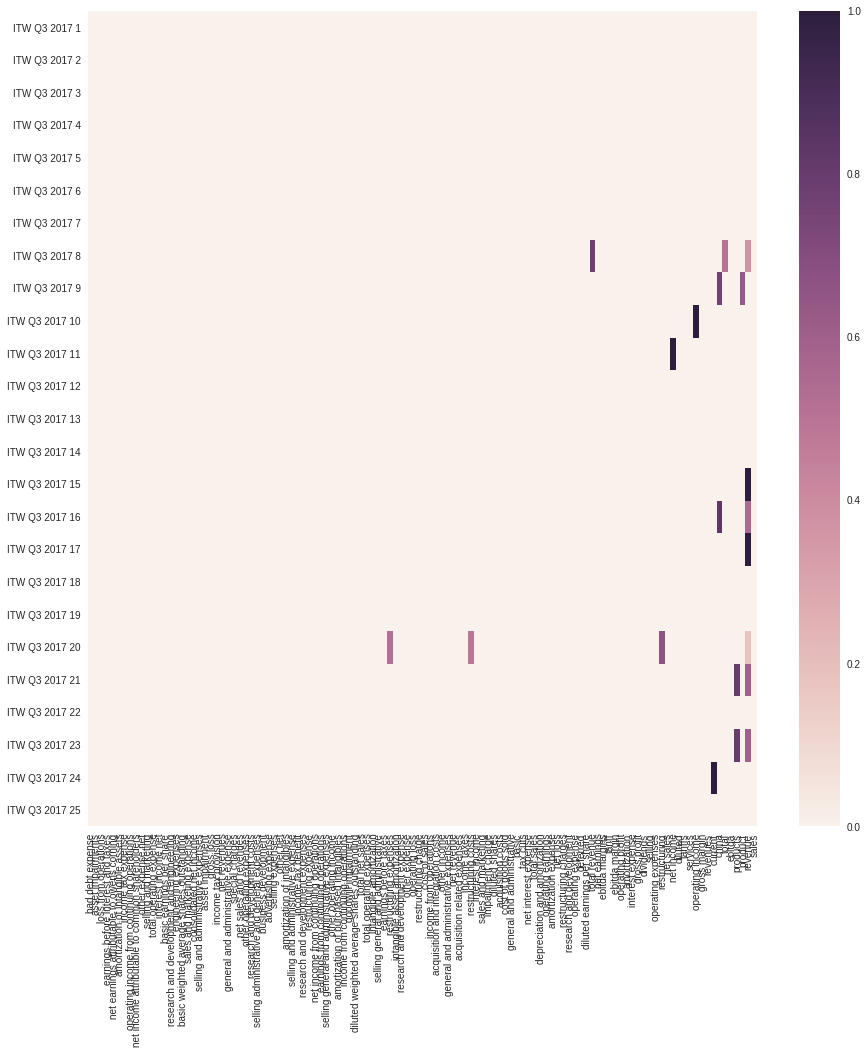

In [269]:
fig = plt.figure(figsize=(15,15))
x = results.iloc[0:25,]
sns.heatmap(x)
plt.show()

#### Heatmap of Term by Paragraph

https://www.fool.com/earnings/call-transcripts/2018/11/01/aaon-inc-aaon-q3-2018-earnings-conference-call-tra.aspx


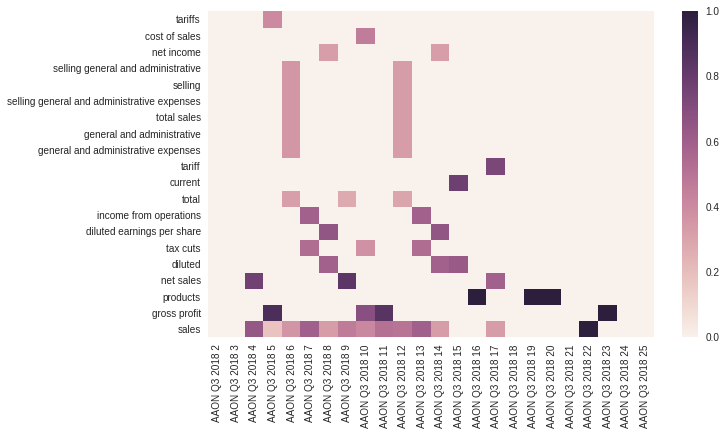


https://www.fool.com/earnings/call-transcripts/2019/03/02/aaon-inc-aaon-q4-2018-earnings-conference-call-tra.aspx


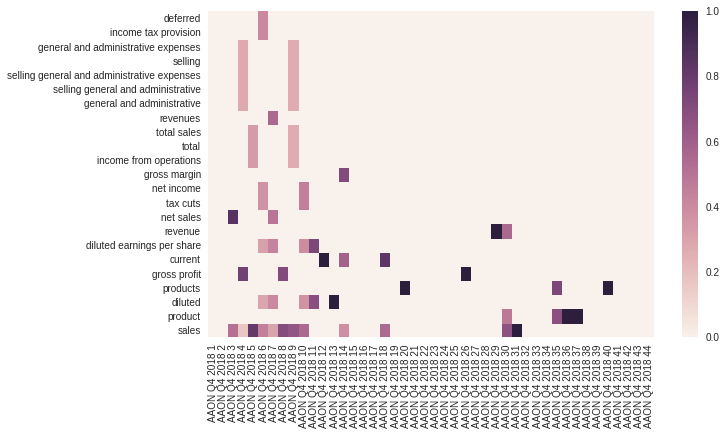

In [270]:
num_calls = 2
for _, row in calls_to_use[0:num_calls].iterrows():
    print(row.name)
    prepared_remarks = df_text[(df_text["Call Section"]=="Prepared Remarks")&
                               (df_text["Speaker"]!="Operator")&
                               (df_text["Link"]==row["Link"])]
    
    corpus = list(prepared_remarks["Text"])
    corpus = [clean_paragraph(paragraph) for paragraph in corpus]
    tfidf_vectorizer = TfidfVectorizer(ngram_range=(min_ngram, max_ngram),vocabulary=line_items)
    tfidf = tfidf_vectorizer.fit_transform(corpus)

    results = pd.DataFrame(data=tfidf.toarray(), index=prepared_remarks.index.values, columns=tfidf_vectorizer.get_feature_names())
    make_heatmap(results)    
    print()

<br>
<br>
<hr>
## Topic Modeling:  Unsupervised - Assign a Topic to Each Paragraph

#### Add to Stop Lists Based on Companies

In [0]:
removal_list = ["The","International","Incorporated","Inc","Corporation","Corp","Group","Holdings","Company","Co.","Brands",".",",","&"]
#removal_list += ["Restaurants","Restaurant","Stores","Store"]

def clean_company_name(name):
    for item in removal_list:
        name = name.replace(item,"")
    return name.strip()

company_stop_words = np.unique([clean_company_name(x) for x in calls_to_use["company"].values])

In [0]:
#[stop.add(x) for x in company_stop_words]

#### Build Corpus

In [273]:
corpus, named_ents, call_names, paragraph_nums, corpus_whole_calls, call_names_whole_calls = [], [], [], [], [], []

num_calls = 2
for _, row in calls_to_use[0:num_calls].iterrows():
    print(row["Link"])
    prepared_remarks = df_text[df_text["Link"]==row["Link"]]
    prepared_remarks = prepared_remarks[(prepared_remarks["Call Section"]=="Prepared Remarks")
                                        &(prepared_remarks["Speaker"]!="Operator")]
    
    #corpus += list(prepared_remarks["Cleaned Text"])
    cleaned_text_for_call = [clean(paragraph) for paragraph in prepared_remarks["Text"]]
    corpus += cleaned_text_for_call
    
    for paragraph in prepared_remarks["Text"]:
        ents = spacynlp(paragraph).ents
        named_ents.append([ent.text.replace("\n","").upper() for ent in ents])
    
    call_names += list(prepared_remarks.index)
    
    paragraph_nums  += list(prepared_remarks["Call Paragraph Num"])
    
    corpus_whole_calls.append(" ".join(cleaned_text_for_call))
    call_names_whole_calls.append(row["ticker"] + " " + row["period"])


https://www.fool.com/earnings/call-transcripts/2018/11/01/aaon-inc-aaon-q3-2018-earnings-conference-call-tra.aspx
https://www.fool.com/earnings/call-transcripts/2019/03/02/aaon-inc-aaon-q4-2018-earnings-conference-call-tra.aspx


#### Scikit Learn Topic Modeling

In [274]:
n_components = 25
n_top_words = 5

tfidf_vectorizer  = TfidfVectorizer(ngram_range=(1,1),min_df=0.001,max_df=0.25)
tfidf = tfidf_vectorizer .fit_transform(corpus)
nmf = NMF(n_components=n_components, random_state=1, alpha=.1, l1_ratio=.5).fit(tfidf)
tfidf_feature_names = tfidf_vectorizer.get_feature_names()
print_top_words(nmf, tfidf_feature_names, n_top_words)

W = nmf.fit_transform(tfidf)
df_topics = pd.DataFrame(W,index=call_names)

Topic #0: 
'share per earnings diluted decreased'

Topic #1: 
'price increase backlog june weve'

Topic #2: 
'sga decrease expense increased percentage'

Topic #3: 
'tax rate effective decreased act'

Topic #4: 
'statement aaons looking forward including'

Topic #5: 
'31 december increase net result'

Topic #6: 
'capital 31 balance december expenditure'

Topic #7: 
'gross profit quarter company compared'

Topic #8: 
'open question moderator ill that'

Topic #9: 
'lab believe exists anywhere ton'

Topic #10: 
'turn like detail discus id'

Topic #11: 
'young east debt deal day'

Topic #12: 
'september net 30 month mainly'

Topic #13: 
'market went 50 change commercial'

Topic #14: 
'another quarter one increase likewise'

Topic #15: 
'attractive customer upon 32 astoundingly'

Topic #16: 
'scheduled lab april utilization target'

Topic #17: 
'compounded aaon annual growth per'

Topic #18: 
'talk curve painstaking catching materialize'

Topic #19: 
'young woman instead appointed is'

Topi

In [275]:
df_topics[4].sort_values(ascending=False).head(10)

AAON Q3 2018 2     1.177043
AAON Q4 2018 1     1.025454
AAON Q4 2018 2     0.519422
AAON Q4 2018 26    0.129147
AAON Q4 2018 7     0.000000
AAON Q4 2018 6     0.000000
AAON Q4 2018 5     0.000000
AAON Q4 2018 4     0.000000
AAON Q4 2018 3     0.000000
AAON Q4 2018 9     0.000000
Name: 4, dtype: float64

In [276]:
df_topics.loc["AAON Q4 2018 1",].sort_values(ascending=False).head(10)

4     1.025454
24    0.000000
11    0.000000
1     0.000000
2     0.000000
3     0.000000
5     0.000000
6     0.000000
7     0.000000
8     0.000000
Name: AAON Q4 2018 1, dtype: float64

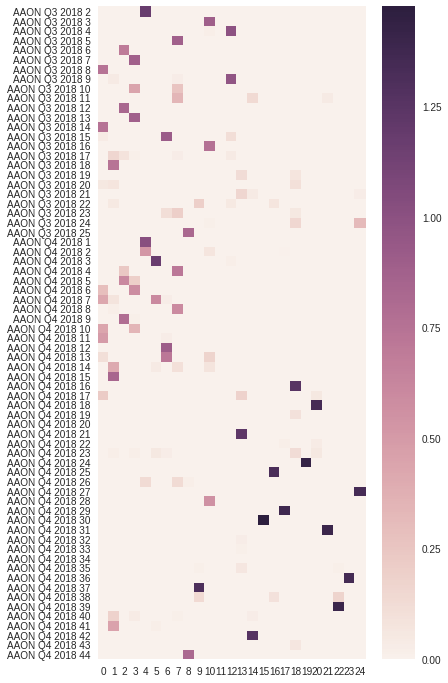

In [277]:
f,axs = plt.subplots(1,1,figsize=(6,12))
sns.heatmap(df_topics)

<br>
<br>
<hr>
## Topic Modeling:  Text Summarization using Text Rank

In [0]:
! pip install summa
clear_output()

In [0]:
from summa import keywords
from summa.summarizer import summarize

corpus, named_ents, call_names, paragraph_nums, corpus_whole_calls, call_names_whole_calls = [], [], [], [], [], []

num_calls = 10
for _, row in calls_to_use[0:num_calls].iterrows():
    prepared_remarks = df_text[(df_text["Call Section"]=="Prepared Remarks")&
                               (df_text["Speaker"]!="Operator")&
                               (df_text["Link"]==row["Link"])]
    
    corpus += [keywords.keywords(clean_paragraph_very_manual(paragraph), ratio=0.1, additional_stopwords=addl_stopwords).split() 
               for paragraph in prepared_remarks["Text"]]   
    call_names += list(prepared_remarks.index)

results = pd.DataFrame(corpus,index=call_names)

In [0]:
callID = "AIMC Q3 2018 22"
results.loc[callID]

<br>
<br>
<hr>
## Next Technique:  Cross Document Structure

## Next Technique:  Text Tiling

## Next Technique:  Topic Tiling

## Next Technique:  Text Reuse (Croft)

<br>
<br>
<hr>
## Call Links

In [280]:
calls_to_use[calls_to_use["ticker"]=="ROK"].index

Index(['https://www.fool.com/earnings/call-transcripts/2018/11/07/rockwell-automation-inc-rok-q4-2018-earnings-confe.aspx', 'https://www.fool.com/earnings/call-transcripts/2019/01/29/rockwell-automation-inc-rok-q1-2019-earnings-confe.aspx'], dtype='object')

<br>
<br>
<hr>
## Testing

In [0]:
# builds the corpus at paragraph and entire call level
num_calls = 10
corpus, named_ents, call_names, paragraph_nums, corpus_whole_calls, call_names_whole_calls = [], [], [], [], [], []
for _, row in calls_to_use[0:num_calls].iterrows():
    link = row["Link"] 
    print(link)

    prepared_remarks = df_text[(df_text["Call Section"]=="Prepared Remarks")&
                               (df_text["Speaker"]!="Operator")&
                               (df_text["Link"]==link)]
    prepared_remarks = prepared_remarks.loc[prepared_remarks.index.difference(compliance_paragraphs)]
    cleaned_text_for_call = [clean_paragraph_very_manual(paragraph) for paragraph in prepared_remarks["Text"]]

    corpus += cleaned_text_for_call
    call_names += list(prepared_remarks.index)
    paragraph_nums  += list(prepared_remarks["Call Paragraph Num"])
    
    corpus_whole_calls.append(" ".join(cleaned_text_for_call))
    call_names_whole_calls.append(row["ticker"] + " " + row["period"])